In [1]:
# !pip install nibabel
# !pip install timm
# !pip install einops
# !pip install pytorch_lightning
# !pip install monai 

In [2]:
#!pip install tensorflow
#!pip install tensorboard 

In [40]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from typing import Union, List
import numpy as np
from timm.models.layers import trunc_normal_
import pytorch_lightning as pl 
import monai
#import pytorch_lightning as pl
from monai import transforms
from monai.data import Dataset
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from monai.config import KeysCollection
from monai.losses import DiceLoss, DiceFocalLoss, DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric, ConfusionMatrixMetric, MeanIoU
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.data import decollate_batch
#from monai.data import NiftiSaver, write_nifti
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Resized,
    Spacingd,
    ScaleIntensityd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    ConvertToMultiChannelBasedOnBratsClassesd,
    SpatialPadd,
    ScaleIntensityRangePercentilesd,
)

import pandas as pd
#IMPORT THE RES SWIN UNET MODEL 

from ResSwinUnet import swinUnet_t_3D_Residual

In [31]:
# !pip install torchio

In [41]:
import nibabel as nib
#from celluloid import Camera
#import torchio as tio

In [42]:

dataset_path = './scratch/MICCAI_BraTS2020_TrainingData'

sample_path = './scratch/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355'

sample_scan_paths = os.listdir(sample_path)

img_names = ['flair','mask','t1','t1ce','t2']

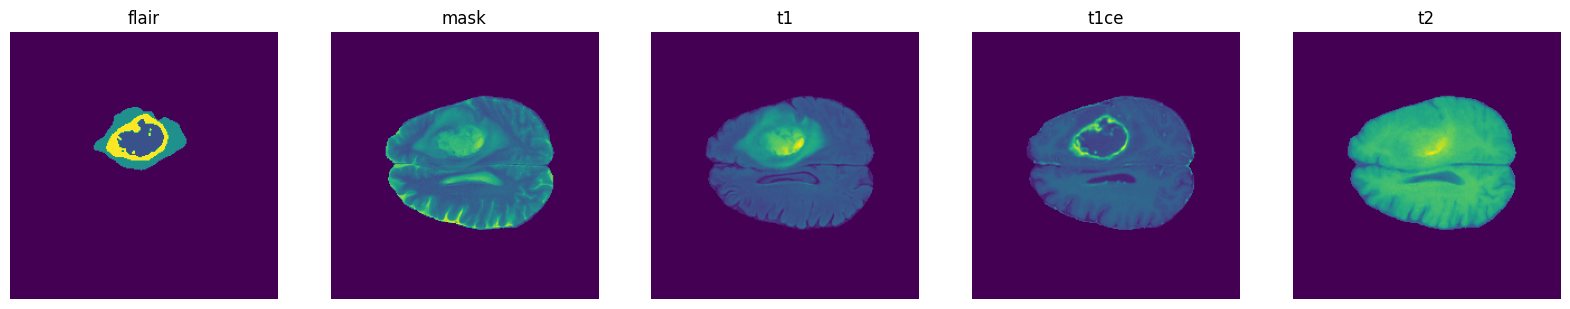

In [43]:
#DISPLAYING ALL 4 MODALITIES (FLAR, T1, T1CE, T2 ) AND THE GROUND TRUTH MASK FROM A SAMPLE SCAN 
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

for i in range(5):
    img_path = os.path.join(sample_path, sample_scan_paths[i])
    img = nib.load(img_path)
    img = img.get_fdata()

    ax[i].imshow(img[:, :, 95])
    ax[i].set_title(img_names[i])
    ax[i].axis('off')

plt.show()

In [44]:
#SAVING PATHS OF ALL 4 MODALITIES AND THE GROUND TRUTH MASK IN SEPARATE LISTS 

flair_paths = []
t1_paths = []
t1ce_paths = []
t2_paths = []
seg_paths = []

for i in os.listdir(dataset_path):
    
    
    for j in os.listdir(os.path.join(dataset_path, i)):
        if(j.endswith('flair.nii.gz')):
            flair_paths.append(os.path.join(dataset_path, i, j))

        elif(j.endswith('t1.nii.gz')):
            t1_paths.append(os.path.join(dataset_path, i, j))

        elif(j.endswith('t1ce.nii.gz')):
            t1ce_paths.append(os.path.join(dataset_path, i, j))

        elif(j.endswith('t2.nii.gz')):
            t2_paths.append(os.path.join(dataset_path, i, j))

        elif(j.endswith('seg.nii.gz')):
            seg_paths.append(os.path.join(dataset_path, i, j))

In [45]:
# !pip install scikit-image

In [46]:
#WE WANT THE INPUT TO BE FED AS A FOUR CHANNEL IMAGE WHICH CONTAINS ALL 4 MODALITIES 

train_x = []
train_y = []

for i in range(len(flair_paths)):
    
    flair_path = flair_paths[i]
    t1_path = t1_paths[i]
    t1ce_path = t1ce_paths[i]
    t2_path = t2_paths[i]
    seg_path = seg_paths[i]
    
    files = [flair_path,t1_path,t1ce_path,t2_path]
    
    train_x.append(files)
    train_y.append(seg_path)
    
    
    
    

In [47]:
#CREATING A DICTIONARY TO SAVE ALL IMAGES AND LABELS 

train_dict = []

for x, y in zip(train_x, train_y):
    info = {'image': x, 'label': y}
    train_dict.append(info)

In [48]:
seed = 3407  
spacings = [1.0, 1.0, 1.0]

#REGION OF INTEREST SIZE = 128*128*128 
RoiSize = [128, 128, 128]  

#SLIDING WINDOW SIZE = 4*4*4
window_size = [it // 32 for it in RoiSize]  


overlap = 0.125

#SINCE WE ARE USING ALL 4 MODALITIES, THE INPUT CHANNELS WILL BE 4
in_channels = 4

l_percent = 0.5
u_percent = 99.5

train_ratio, val_ratio, test_ratio = [0.7, 0.15, 0.15]

#VARY BATCH SIZE AND THREADS (WORKERS) ACCORDING TO THE CAPACITY OF YOUR MACHINE  

BatchSize = 1
NumWorkers = 4  

#CHANGE MAX EPOCH AND MIN EPOCH ACCORDINGLY

max_epoch = 550
min_epoch = 500

'''
The t_max parameter in the Cosine Annealing Learning Rate (LR) scheduler refers to the maximum number of iterations 
(or epochs) after which the learning rate will complete one cosine cycle.

In Cosine Annealing, the learning rate starts at a high value and decreases following a cosine curve until it reaches 
a minimum value (often very close to 0). Once the t_max number of iterations is reached, 
the scheduler restarts the process, and the learning rate begins increasing again.
'''

LRCycle = 10 #tmax parameter to be used for cosine annealing learning rate scheduler 
'''
ED (peritumoral edema) =  2,ET (enhancing tumor) =  4, 
NET (non-enhancing tumor)  1, 0- NOT TUMOR 
WT = ED + ET + NET
TC = ET+NET
ET
'''
n_classes = 3  #TC, ET, WT

#lr = 3e-4  

# ValidSegDir = os.path.join(data_path, 'ValidSeg', model_name)
# PredDataDir = os.path.join(data_path, 'Brats2021Pred')
# PredSegDir = os.path.join(data_path, 'PredSeg', model_name)

In [49]:
'''
WT = ED + ET + NET
TC = ET+NET
ET

Below is the class for computing WT, TC and ET 
'''

class ReverseBratsLabel(transforms.Transform):
    def __call__(self, pred):
        pred = pred.bool()
        tc = pred[0, ::]
        wt = pred[1, ::]
        et = pred[2, ::]
        res = torch.zeros(pred.shape[1:])

        # label_4 = et
        # label_2 = wt - tc
        # label_1 = tc - et

        label_4 = et
        label_2 = torch.logical_and(wt, torch.logical_not(tc))
        label_1 = torch.logical_and(tc, torch.logical_not(et))

        res[label_1] = 1
        res[label_2] = 2
        res[label_4] = 4
        return res

In [50]:
#transforms for training data 

train_process = Compose(
            [
                # load 4 Nifti images and stack them together
                LoadImaged(keys=["image", "label"]),
                
                #ensuring that the channels are the first dimension for image and label 
                EnsureChannelFirstd(keys="image"),
                ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),

                #ensuring that both image and labels are of the same orientation
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(keys=["image", "label"], pixdim=spacings,
                         mode=("bilinear", "nearest"), ),
                 

                RandSpatialCropd(keys=["image", "label"], roi_size=RoiSize, random_size=False),
                
                
                #performing flipping with probability of 0.5 along all 3 axes 
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),

                NormalizeIntensityd(keys="image", nonzero=True,
                                    channel_wise=True),
                RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
                RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),

                EnsureTyped(keys=["image", "label"]),
            ]
        )

In [51]:
#transforms for validation data 

val_process = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys="image"),
                ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=spacings,
                    mode=("bilinear", "nearest"),
                ),
                RandSpatialCropd(keys=["image", "label"], roi_size=RoiSize, random_size=False),
                #Resized(keys=['image','label'], spatial_size=(128,128,128), mode=['area','nearest']),
                #ScaleIntensityd(keys='image', minv=0.0, maxv=1.0), 
                NormalizeIntensityd(keys="image", nonzero=True,
                                    channel_wise=True),
                EnsureTyped(keys=["image", "label"]),
            ]
        )

In [52]:
#transforms for test data 

test_process = Compose([
            LoadImaged(keys=['image','label']),
            EnsureChannelFirstd(keys='image'),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            Orientationd(keys=['image','label'], axcodes="RAS"),
            Spacingd(keys=["image","label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            RandSpatialCropd(keys=["image", "label"], roi_size=RoiSize, random_size=False),
            #Resized(keys=['image','label'], spatial_size=(128,128,128), mode=['area','nearest']),
            #ScaleIntensityd(keys='image', minv=0.0, maxv=1.0), 
            #NormalizeIntensityd(keys='image', nonzero=True, channel_wise=True),
            EnsureTyped(keys=["image", "label"]),
        ])

In [53]:
num = len(train_dict)
train_num = int(num * train_ratio) #0.7
val_test_num = int(num * val_ratio) #0.15
if train_num + val_test_num != num: 
    remain = num - train_num - val_test_num
    val_test_num += remain
    
    
#259 - 70%, 55 - 15%, 55 - 15%
train_dict, val_test_dict = random_split(train_dict, [259, 110],
                                    generator=torch.Generator().manual_seed(seed))

In [54]:
train_dict[0]

{'image': ['./scratch/MICCAI_BraTS2020_TrainingData/BraTS20_Training_338/BraTS20_Training_338_flair.nii.gz',
  './scratch/MICCAI_BraTS2020_TrainingData/BraTS20_Training_338/BraTS20_Training_338_t1.nii.gz',
  './scratch/MICCAI_BraTS2020_TrainingData/BraTS20_Training_338/BraTS20_Training_338_t1ce.nii.gz',
  './scratch/MICCAI_BraTS2020_TrainingData/BraTS20_Training_338/BraTS20_Training_338_t2.nii.gz'],
 'label': './scratch/MICCAI_BraTS2020_TrainingData/BraTS20_Training_338/BraTS20_Training_338_seg.nii.gz'}

In [55]:
len(train_dict)

259

In [56]:
val_dict, test_dict = random_split(val_test_dict, [55, 55],
                                    generator=torch.Generator().manual_seed(seed))

In [57]:
len(val_dict)

55

In [58]:
len(test_dict)

55

In [59]:
train_set = Dataset(train_dict, transform=train_process)
val_set = Dataset(val_dict, transform=val_process)
test_set = Dataset(test_dict, transform = test_process)

In [60]:
#CREATING TRAIN LOADER, VAL LOADER AND TEST LOADERS 

train_loader = DataLoader(train_set, batch_size=BatchSize, num_workers=NumWorkers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BatchSize, num_workers=NumWorkers, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BatchSize,num_workers=NumWorkers, shuffle=False)

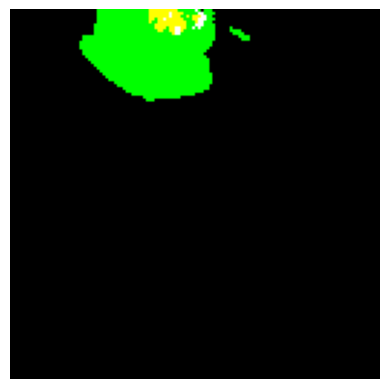

In [65]:
#visualizing a sample ground truth mask 

#GREEN IS THE BOUNDARY FOR THE WHOLE TUMOR, YELLOW IS ENHANCED TUMOR, WHITE IS TUMOR CORE 
for i,batch in enumerate(train_loader):
    lbl_slice = batch["label"][0,:,:,:,75]
    lbl_transposed = np.transpose(lbl_slice,(1,2,0))
    plt.imshow(lbl_transposed)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    
    break

In [66]:
#INSTANTIATING THE MODEL

model = swinUnet_t_3D_Residual()

In [67]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 48115676


In [68]:
def visualize_prediction(image, pred, label, slice_num=78):
    """
    Visualize a single slice of the 3D image, predicted mask, and ground truth.
    """
    # Select a particular slice for visualization
    
    #print("shape of image = ",image.shape)
    img_slice = image[0, 2, :, :, slice_num].cpu().numpy()
    pred_slice = pred[0, 0, :, :, slice_num].cpu().numpy()
    label_slice = label[0,:,:, :, slice_num].cpu().numpy()

    # Plot image, predicted mask, and ground truth side by side
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_slice)
    ax[0].set_title("Image Slice")

    ax[1].imshow(pred_slice)
    ax[1].set_title("Predicted Mask")
    
    image_transposed = np.transpose(label_slice, (1, 2, 0))


    ax[2].imshow(image_transposed)
    ax[2].set_title("Ground Truth Mask")

    plt.show()

In [69]:
#CREATING THE DATA MODULE WHICH UTILIZES THE DATA LOADERS 

class BratsDataModule(pl.LightningDataModule):
    def __init__(self):
        
        super().__init__()
        
    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader
    
    def predict_dataloader(self):
        return test_loader

    

In [73]:
#CREATING THE MODULE WHICH HANDLES THE TRAINING AND VALIDATION PROCESS

class BratsModel(pl.LightningModule):
    def __init__(self,learning_rate):
        super(BratsModel, self).__init__()
        
        self.learning_rate = learning_rate 
        self.net = model
        
        # Initialize lists to store loss and dice values
        self.train_losses = []
        self.valid_losses = []
        self.tc_train_dice = []
        self.wt_train_dice = []
        self.et_train_dice = []
        self.tc_valid_dice = []
        self.wt_valid_dice = []
        self.et_valid_dice = []
        
        #initialize lists to store all the metrics for individual classes for validation data 
        self.tc_valid_mean_sens = []
        self.tc_valid_mean_spec = []
        self.tc_valid_mean_acc = []
        self.tc_valid_mean_prec = []
        self.tc_valid_mean_iou = []
        
        self.et_valid_mean_sens = []
        self.et_valid_mean_spec = []
        self.et_valid_mean_acc = []
        self.et_valid_mean_prec = []
        self.et_valid_mean_iou = []
        
        self.wt_valid_mean_sens = []
        self.wt_valid_mean_spec = []
        self.wt_valid_mean_acc = []
        self.wt_valid_mean_prec = []
        self.wt_valid_mean_iou = []
        

        self.loss_func = DiceLoss(smooth_nr=0, smooth_dr=1e-5,
                                  to_onehot_y=False,
                                  sigmoid=True, )
        self.dice_metrics = [
            DiceMetric(include_background=True,
                       reduction="mean_batch"
                       ),
            DiceMetric(include_background=True,
                       reduction="mean_batch"
                       )
        ]
        # self.HD_metric = HausdorffDistanceMetric(include_background=True, reduction='mean_batch')
        
        #this transform will convert the model predictions to binary using sigmoid activation
        self.post_trans = Compose([EnsureType(),
                                   Activations(sigmoid=True),
                                   AsDiscrete(threshold=0.5)])
        self.label_reverse = ReverseBratsLabel()
        
        #confusion matrix will be used to calculate performance metrics like sensitivity, specificity, accuracy, precision
        self.confusion_matrix = [ConfusionMatrixMetric(include_background=True, reduction="mean_batch"),
                           ConfusionMatrixMetric(include_background=True, reduction="mean_batch")]
        
        
        self.mean_iou_metric = [MeanIoU(include_background=True, reduction="mean_batch"),
                               MeanIoU(include_background=True, reduction="mean_batch")] 

    def configure_optimizers(self):
        
        #USING ADAM OPTIMIZER 
        opt = optim.AdamW(params=self.net.parameters(),
                          lr=self.learning_rate, eps=1e-7,
                          weight_decay=1e-5)

        #COSINE ANNEALING LEARNING RATE SCHEDULER 
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=LRCycle)
        return {'optimizer': opt, 'lr_scheduler': lr_scheduler, 'monitor': 'valid_mean_loss'}
    
    
    #THIS FUNCTION HANDLES TRAINING FOR EVERY TRAINING BATCH
    def training_step(self, batch, batch_idx):
        #cfg = self.cfg
        x = batch['image']
        y = batch['label'].float()
        y_hat = self.net(x)

        loss, dices, sensitivity, specificity, accuracy, precision, mean_iou = self.shared_step(y_hat, y, 0)
        #loss, dices = self.shared_step(y_hat, y, 0)
        tc_dice, wt_dice, et_dice = dices[0], dices[1], dices[2]
        tc_sens, wt_sens, et_sens = list(sensitivity.values())[0], list(sensitivity.values())[1], list(sensitivity.values())[2]
        tc_spec, wt_spec, et_spec = list(specificity.values())[0], list(specificity.values())[1], list(specificity.values())[2]
        tc_acc, wt_acc, et_acc = list(accuracy.values())[0], list(accuracy.values())[1], list(accuracy.values())[2]
        tc_prec, wt_prec, et_prec = list(precision.values())[0], list(precision.values())[1], list(precision.values())[2]
        tc_iou, wt_iou, et_iou = mean_iou[0], mean_iou[1], mean_iou[2]
        
        
        #UNCOMMENT TO SEE THE GROUND TRUTH AND PREDICTION COMPARISON DURING TRAINING 
        
        #y_hat = self.post_trans(y_hat)
        #y_hat = [self.label_reverse(i) for i in y_hat]
        #y_hat = torch.stack(y_hat)  # B,H,W,D
        #y_hat = torch.unsqueeze(y_hat, dim=1)
        
        #plt.figure(figsize=(15, 5))

        # First subplot
        #plt.subplot(1, 3, 1)  # (rows, cols, index)
        #plt.imshow(x.detach().cpu()[0,2,:,:,75],cmap='gray')
        #plt.title('Input')
        #plt.axis('off')  # Hide axis

        # Second subplot
        #plt.subplot(1, 3, 2)
        #img_transposed = np.transpose(y.detach().cpu()[0,:,:,:,75],(1,2,0))
        #plt.imshow(img_transposed)
        #plt.title('ground Truth')
        #plt.axis('off')

        # Third subplot
        #plt.subplot(1, 3, 3)
        #plt.imshow(y_hat.detach().cpu()[0,0,:,:,75])
        #plt.title('Prediction')
        #plt.axis('off')

        # Show the plots
        #plt.tight_layout()  # Adjust layout to prevent overlap
        #plt.show()

        self.log('train_tc_dice', tc_dice, prog_bar=True)
        self.log('train_et_dice', et_dice, prog_bar=True)
        self.log('train_wt_dice', wt_dice, prog_bar=True)

        self.log('train_loss', loss, prog_bar=True)
        
        self.log('tc_sens_train', tc_sens, prog_bar=True)
        self.log('tc_spec_train', tc_spec, prog_bar=True)
        self.log('tc_acc_train', tc_acc, prog_bar=True)
        #self.log('tc_f1', tc_f1, prog_bar=True)
        self.log('tc_prec_train', tc_prec, prog_bar=True)
        self.log('tc_iou_train', tc_iou, prog_bar=True)
        
        self.log('et_sens_train', et_sens, prog_bar=True)
        self.log('et_spec_train', et_spec, prog_bar=True)
        self.log('et_acc_train', et_acc, prog_bar=True)
        #self.log('et_f1', et_f1, prog_bar=True)
        self.log('et_prec_train', et_prec, prog_bar=True)
        self.log('et_iou_train', et_iou, prog_bar=True)
        
        self.log('wt_sens_train', wt_sens, prog_bar=True)
        self.log('wt_spec_train', wt_spec, prog_bar=True)
        self.log('wt_acc_train', wt_acc, prog_bar=True)
        #self.log('wt_f1', wt_f1, prog_bar=True)
        self.log('wt_prec_train', wt_prec, prog_bar=True)
        self.log('wt_iou_train', wt_iou, prog_bar=True)
        
        

        return {'loss': loss, 'train_dice': dices,  'tc_sens_train': tc_sens,
            'tc_spec_train': tc_spec, 'tc_acc_train': tc_acc,'tc_prec_train': tc_prec,
            'tc_iou_train': tc_iou, 'et_sens_train': et_sens,'et_spec_train': et_spec,
            'et_acc_train': et_acc, 'et_prec_train': et_prec, 'et_iou_train': et_iou, 
            'wt_sens_train': wt_sens, 'wt_spec_train': wt_spec,'wt_acc_train': wt_acc,
            'wt_prec_train': wt_prec, 'wt_iou_train': wt_iou}
    
    
    #THIS FUNCTION HANDLES VALIDATION FOR EVERY VALIDATION BATCH
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            x = batch['image']
            y = batch['label'].float()
            y_hat = self.net(x)
            
            
            loss, dices, sensitivity, specificity, accuracy, precision, mean_iou = self.shared_step(y_hat, y, 1)
            tc_dice, wt_dice, et_dice = dices[0], dices[1], dices[2]
            tc_sens, wt_sens, et_sens = list(sensitivity.values())[0], list(sensitivity.values())[1], list(sensitivity.values())[2]
            tc_spec, wt_spec, et_spec = list(specificity.values())[0], list(specificity.values())[1], list(specificity.values())[2]
            tc_acc, wt_acc, et_acc = list(accuracy.values())[0], list(accuracy.values())[1], list(accuracy.values())[2]
            tc_prec, wt_prec, et_prec = list(precision.values())[0], list(precision.values())[1], list(precision.values())[2]
            tc_iou, wt_iou, et_iou = mean_iou[0], mean_iou[1], mean_iou[2]
            

            self.log('valid_tc_dice', tc_dice, prog_bar=True)
            self.log('valid_et_dice', et_dice, prog_bar=True)
            self.log('valid_wt_dice', wt_dice, prog_bar=True)

            self.log('valid_loss', loss, prog_bar=True)
            
            self.log('tc_sens_valid', tc_sens, prog_bar=True)
            self.log('tc_spec_valid', tc_spec, prog_bar=True)
            self.log('tc_acc_valid', tc_acc, prog_bar=True)
            self.log('tc_prec_valid', tc_prec, prog_bar=True)
            self.log('tc_iou_valid', tc_iou, prog_bar=True)

            self.log('et_sens_valid', et_sens, prog_bar=True)
            self.log('et_spec_valid', et_spec, prog_bar=True)
            self.log('et_acc_valid', et_acc, prog_bar=True)
            self.log('et_prec_valid', et_prec, prog_bar=True)
            self.log('et_iou_valid', et_iou, prog_bar=True)

            self.log('wt_sens_valid', wt_sens, prog_bar=True)
            self.log('wt_spec_valid', wt_spec, prog_bar=True)
            self.log('wt_acc_valid', wt_acc, prog_bar=True)
            self.log('wt_prec_valid', wt_prec, prog_bar=True)
            self.log('wt_iou_valid', wt_iou, prog_bar=True)
            
            #UNCOMMENT TO SEE THE GROUND TRUTH AND PREDICTION DURING VALIDATION 
            
            #y_hat = self.post_trans(y_hat)
            #y_hat = [self.label_reverse(i) for i in y_hat]
            #y_hat = torch.stack(y_hat)  # B,H,W,D
            #y_hat = torch.unsqueeze(y_hat, dim=1)

            #plt.figure(figsize=(15, 5))

            # First subplot
            #plt.subplot(1, 3, 1)  # (rows, cols, index)
            #plt.imshow(x.detach().cpu()[0,2,:,:,75],cmap='gray')
            #plt.title('Input')
            #plt.axis('off')  # Hide axis

            # Second subplot
            #plt.subplot(1, 3, 2)
            #img_transposed = np.transpose(y.detach().cpu()[0,:,:,:,75],(1,2,0))
            #plt.imshow(img_transposed)
            #plt.title('ground Truth')
            #plt.axis('off')

            # Third subplot
            #plt.subplot(1, 3, 3)
            #plt.imshow(y_hat.detach().cpu()[0,0,:,:,75])
            #plt.title('Prediction')
            #plt.axis('off')

            # Show the plots
            #plt.tight_layout()  # Adjust layout to prevent overlap
            #plt.show()
            
            #SAVE THE INPUT IMAGE AND ITS CORRESPONDING LABELS AND OUTPUTS 
            
            input_dir_flair = f'./scratch/Model_Results/Corresponding_Inputs/flair/learning_rate_{self.learning_rate}'
            input_dir_t1 = f'./scratch/Model_Results/Corresponding_Inputs/t1/learning_rate_{self.learning_rate}'
            input_dir_t1ce = f'./scratch/Model_Results/Corresponding_Inputs/t1ce/learning_rate_{self.learning_rate}'
            input_dir_t2 = f'./scratch/Model_Results/Corresponding_Inputs/t2/learning_rate_{self.learning_rate}'
            output_dir = f'./scratch/Model_Results/Segmentation_Outputs/learning_rate_{self.learning_rate}'
            ground_truth_dir = f'./scratch/Model_Results/Ground_Truths/learning_rate_{self.learning_rate}'
            
            if not os.path.exists(input_dir_flair):
                os.makedirs(input_dir_flair)
                
            if not os.path.exists(input_dir_t1):
                os.makedirs(input_dir_t1)
                
            if not os.path.exists(input_dir_t1ce):
                os.makedirs(input_dir_t1ce)
                
            if not os.path.exists(input_dir_t2):
                os.makedirs(input_dir_t2)
            
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                
            if not os.path.exists(ground_truth_dir):
                os.makedirs(ground_truth_dir)
                
                
            
            if wt_dice > 0.85 and tc_dice > 0.75 and et_dice > 0.75: 
                
                #SAVING INPUTS
                
                x_flair = x[0,0,:,:,:].detach().cpu()
                x_t1 = x[0,1,:,:,:].detach().cpu()
                x_t1ce = x[0,2,:,:,:].detach().cpu()
                x_t2 = x[0,3,:,:,:].detach().cpu()
                
                x_flair_np = x_flair.numpy()
                x_t1_np = x_t1.numpy()
                x_t1ce_np = x_t1ce.numpy()
                x_t2_np = x_t2.numpy()
                
                nii_flair_img = nib.Nifti1Image(x_flair_np,affine=np.eye(4))
                nii_t1_img = nib.Nifti1Image(x_t1_np,affine=np.eye(4))
                nii_t1ce_img = nib.Nifti1Image(x_t1ce_np,affine=np.eye(4))
                nii_t2_img = nib.Nifti1Image(x_t2_np,affine=np.eye(4))
                
                #SAVING PREDICTIONS
                
                y_hat = y_hat.detach().cpu()  
                y_hat = self.post_trans(y_hat)
                y_hat = [self.label_reverse(i) for i in y_hat]  
                y_hat = torch.stack(y_hat)  
                y_hat = torch.unsqueeze(y_hat, dim=1)  
                y_hat_np = y_hat.numpy()
                nii_out_image = nib.Nifti1Image(y_hat_np,affine=np.eye(4))
                
                #SAVING GROUND TRUTHS
                
                y = y.detach().cpu()
                y_np = y.numpy()
                nii_gt_image = nib.Nifti1Image(y_np,affine=np.eye(4))
                
                out_file_name = os.path.join(output_dir, f'segmentation_output_wtdice{wt_dice:.4f}_tcdice{tc_dice:.4f}_etdice{et_dice:.4f}.nii.gz')
                gt_file_name = os.path.join(ground_truth_dir,f'ground_truth_image_wtdice{wt_dice:.4f}_tcdice{tc_dice:.4f}_etdice{et_dice:.4f}.nii.gz')
                inp_flair_file_name = os.path.join(input_dir_flair, f'input_image_wtdice{wt_dice:.4f}_tcdice{tc_dice:.4f}_etdice{et_dice:.4f}.nii.gz')
                inp_t1_file_name = os.path.join(input_dir_t1, f'input_image_wtdice{wt_dice:.4f}_tcdice{tc_dice:.4f}_etdice{et_dice:.4f}.nii.gz')
                inp_t1ce_file_name = os.path.join(input_dir_t1ce, f'input_image_wtdice{wt_dice:.4f}_tcdice{tc_dice:.4f}_etdice{et_dice:.4f}.nii.gz')
                inp_t2_file_name = os.path.join(input_dir_t2, f'input_image_wtdice{wt_dice:.4f}_tcdice{tc_dice:.4f}_etdice{et_dice:.4f}.nii.gz')

                # Save all the images 
                nib.save(nii_out_image,out_file_name )
                nib.save(nii_gt_image,gt_file_name )
                nib.save(nii_flair_img,inp_flair_file_name)
                nib.save(nii_t1_img,inp_t1_file_name)
                nib.save(nii_t1ce_img,inp_t1ce_file_name)
                nib.save(nii_t2_img,inp_t2_file_name)
                
            

            return {'valid_loss': loss, 'valid_dice': dices,  'tc_sens_valid': tc_sens,
            'tc_spec_valid': tc_spec, 'tc_acc_valid': tc_acc,'tc_prec_valid': tc_prec,
            'tc_iou_valid': tc_iou, 'et_sens_valid': et_sens,'et_spec_valid': et_spec,
            'et_acc_valid': et_acc, 'et_prec_valid': et_prec, 'et_iou_valid': et_iou, 
            'wt_sens_valid': wt_sens, 'wt_spec_valid': wt_spec,'wt_acc_valid': wt_acc,
            'wt_prec_valid': wt_prec, 'wt_iou_valid': wt_iou}

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        with torch.no_grad():
            img = batch['image']
            y = batch['label'].float()
            #print("shape of test image = ",img.shape)
            #preds = sliding_window_inference(img, roi_size=RoiSize, overlap=overlap,
            #                                 sw_batch_size=1, predictor=self.net)
            
            #print("shape of prediction = ",preds.shape)
            #print(torch.unique(preds))
            preds = self.net(img)
            
            y_hat = self.post_trans(preds)
            y_hat = [self.label_reverse(i) for i in y_hat]
            #print("shape of prediction = ", preds.shape)
            y_hat = torch.stack(y_hat)  # B,H,W,D
            #print("shape of prediction = ",preds.shape)
            y_hat = torch.unsqueeze(y_hat, dim=1)
            #print("shape of unsqueezed prediction = ",y_hat.shape)

            plt.figure(figsize=(15, 5))

            # First subplot
            plt.subplot(1, 3, 1)  # (rows, cols, index)
            plt.imshow(img.detach().cpu()[0,2,:,:,75],cmap='gray')
            plt.title('Input')
            plt.axis('off')  # Hide axis

            # Second subplot
            plt.subplot(1, 3, 2)
            img_transposed = np.transpose(y.detach().cpu()[0,:,:,:,75],(1,2,0))
            plt.imshow(img_transposed)
            plt.title('ground Truth')
            plt.axis('off')

            # Third subplot
            plt.subplot(1, 3, 3)
            plt.imshow(y_hat.detach().cpu()[0,0,:,:,75])
            plt.title('Prediction')
            plt.axis('off')

            # Show the plots
            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()
            #loss, dices = self.shared_step(preds, y, 1)
            #tc_dice, wt_dice, et_dice = dices[0], dices[1], dices[2]


            #self.log('valid_loss', loss, prog_bar=True)
            #print(batch.keys())
            #meta_dict = batch['image_meta_dict']
            #for k, v in meta_dict.items():
            #    if isinstance(v, torch.Tensor):
            #        meta_dict[k] = v.detach().cpu()
            #
            #preds = preds.detach().cpu()
            #preds = self.post_trans(preds)
            #preds = [self.label_reverse(i) for i in preds]
            #print("shape of prediction = ", preds.shape)
            #preds = torch.stack(preds)  # B,H,W,D
            #print("shape of prediction = ",preds.shape)
            #preds = torch.unsqueeze(preds, dim=1)  # 增加通道维度，saver需要的格式为B,C,H,W,D
            #print("unsqueezed prediction shape = ",preds.shape)
            
            #print("unique values in pred = ",torch.unique(preds))
            
            #label = batch['label']  # Get the ground truth labels
    
            # Visualize a single slice
            #visualize_prediction(img, preds, label, slice_num=78)
            
            #saver = NiftiSaver(output_dir=PredSegDir, mode="nearest")
            #saver.save_batch(preds, meta_dict)  # fixme 检查此处用法是否正确
            
            
    #THIS FUNCTION LOGS ALL THE METRICS FOR TRAINING AT THE END OF EVERY EPOCH 
    def on_training_epoch_end(self):
        outputs = self.trainer.callback_metrics
        losses, mean_dice, sens, spec, acc, prec, mean_iou = self.shared_epoch_end('train_loss')
        #losses, mean_dice = self.shared_epoch_end('train_loss')
        if len(losses) > 0:
            mean_loss = torch.mean(losses)
            tc_mean_dice, wt_mean_dice, et_mean_dice = mean_dice[0], mean_dice[1], mean_dice[2]
            tc_mean_sens, wt_mean_sens, et_mean_sens = torch.mean(sens['tc_sens']),torch.mean(sens['wt_sens']),torch.mean(sens['et_sens'])
            tc_mean_spec, wt_mean_spec, et_mean_spec = torch.mean(spec['tc_spec']),torch.mean(spec['wt_spec']),torch.mean(spec['et_spec'])
            tc_mean_acc, wt_mean_acc, et_mean_acc = torch.mean(acc['tc_acc']),torch.mean(acc['wt_acc']),torch.mean(acc['et_acc'])
            tc_mean_prec, wt_mean_prec, et_mean_prec = torch.mean(prec['tc_prec']),torch.mean(prec['wt_prec']),torch.mean(prec['et_prec'])
            tc_mean_iou, wt_mean_iou, et_mean_iou = mean_iou[0], mean_iou[1], mean_iou[2]
            
            
            self.train_losses.append(mean_loss.item())
            self.tc_train_dice.append(tc_mean_dice.item())
            self.wt_train_dice.append(wt_mean_dice.item())
            self.et_train_dice.append(et_mean_dice.item())

            self.log('train_mean_loss', mean_loss, prog_bar=True)
            self.log('tc_train_mean_dice', tc_mean_dice, prog_bar=True)
            self.log('wt_train_mean_dice', wt_mean_dice, prog_bar=True)
            self.log('et_train_mean_dice', et_mean_dice, prog_bar=True)
            
            self.log('tc_train_mean_sens', tc_mean_sens, prog_bar=True)
            self.log('tc_train_mean_spec', tc_mean_spec, prog_bar=True)
            self.log('tc_train_mean_acc', tc_mean_acc, prog_bar=True)
            self.log('tc_train_mean_prec', tc_mean_prec, prog_bar=True)
            self.log('tc_train_mean_iou', tc_mean_iou, prog_bar=True)
            
            self.log('et_train_mean_sens', et_mean_sens, prog_bar=True)
            self.log('et_train_mean_spec', et_mean_spec, prog_bar=True)
            self.log('et_train_mean_acc', et_mean_acc, prog_bar=True)
            self.log('et_train_mean_prec', et_mean_prec, prog_bar=True)
            self.log('et_train_mean_iou', et_mean_iou, prog_bar=True)
            
            self.log('wt_train_mean_sens', wt_mean_sens, prog_bar=True)
            self.log('wt_train_mean_spec', wt_mean_spec, prog_bar=True)
            self.log('wt_train_mean_acc', wt_mean_acc, prog_bar=True)
            self.log('wt_train_mean_prec', wt_mean_prec, prog_bar=True)
            self.log('wt_train_mean_iou', wt_mean_iou, prog_bar=True)
            
            
    #THIS FUNCTION LOGS ALL THE METRICS FOR VALIDATION AT THE END OF EVERY EPOCH
    def on_validation_epoch_end(self):
        outputs = self.trainer.callback_metrics
        losses, mean_dice, sens, spec, acc, prec, mean_iou = self.shared_epoch_end('valid_loss', 1)
        if len(losses) > 0:
            mean_loss = torch.mean(losses)

            tc_mean_dice, wt_mean_dice, et_mean_dice = mean_dice[0], mean_dice[1], mean_dice[2]
            tc_mean_sens, wt_mean_sens, et_mean_sens = torch.mean(sens['tc_sens']),torch.mean(sens['wt_sens']),torch.mean(sens['et_sens'])
            tc_mean_spec, wt_mean_spec, et_mean_spec = torch.mean(spec['tc_spec']),torch.mean(spec['wt_spec']),torch.mean(spec['et_spec'])
            tc_mean_acc, wt_mean_acc, et_mean_acc = torch.mean(acc['tc_acc']),torch.mean(acc['wt_acc']),torch.mean(acc['et_acc'])
            tc_mean_prec, wt_mean_prec, et_mean_prec = torch.mean(prec['tc_prec']),torch.mean(prec['wt_prec']),torch.mean(prec['et_prec'])
            tc_mean_iou, wt_mean_iou, et_mean_iou = mean_iou[0], mean_iou[1], mean_iou[2]
            
            self.valid_losses.append(mean_loss.item())
            self.tc_valid_dice.append(tc_mean_dice.item())
            self.wt_valid_dice.append(wt_mean_dice.item())
            self.et_valid_dice.append(et_mean_dice.item())
            
            self.tc_valid_mean_sens.append(tc_mean_sens.item())
            self.tc_valid_mean_spec.append(tc_mean_spec.item())
            self.tc_valid_mean_acc.append(tc_mean_acc.item())
            self.tc_valid_mean_prec.append(tc_mean_prec.item())
            self.tc_valid_mean_iou.append(tc_mean_iou.item())

            self.et_valid_mean_sens.append(wt_mean_sens.item())
            self.et_valid_mean_spec.append(wt_mean_spec.item())
            self.et_valid_mean_acc.append(wt_mean_acc.item())
            self.et_valid_mean_prec.append(wt_mean_prec.item())
            self.et_valid_mean_iou.append(wt_mean_iou.item())

            self.wt_valid_mean_sens.append(et_mean_sens.item())
            self.wt_valid_mean_spec.append(et_mean_spec.item())
            self.wt_valid_mean_acc.append(et_mean_acc.item())
            self.wt_valid_mean_prec.append(et_mean_prec.item())
            self.wt_valid_mean_iou.append(et_mean_iou.item())
            

            self.log('valid_mean_loss', mean_loss, prog_bar=True)
            self.log('tc_valid_mean_dice', tc_mean_dice, prog_bar=True)
            self.log('wt_valid_mean_dice', wt_mean_dice, prog_bar=True)
            self.log('et_valid_mean_dice', et_mean_dice, prog_bar=True)
            
            self.log('tc_valid_mean_sens', tc_mean_sens, prog_bar=True)
            self.log('tc_valid_mean_spec', tc_mean_spec, prog_bar=True)
            self.log('tc_valid_mean_acc', tc_mean_acc, prog_bar=True)
            self.log('tc_valid_mean_prec', tc_mean_prec, prog_bar=True)
            self.log('tc_valid_mean_iou', tc_mean_iou, prog_bar=True)
            
            self.log('et_valid_mean_sens', et_mean_sens, prog_bar=True)
            self.log('et_valid_mean_spec', et_mean_spec, prog_bar=True)
            self.log('et_valid_mean_acc', et_mean_acc, prog_bar=True)
            self.log('et_valid_mean_prec', et_mean_prec, prog_bar=True)
            self.log('et_valid_mean_iou', et_mean_iou, prog_bar=True)
            
            self.log('wt_valid_mean_sens', wt_mean_sens, prog_bar=True)
            self.log('wt_valid_mean_spec', wt_mean_spec, prog_bar=True)
            self.log('wt_valid_mean_acc', wt_mean_acc, prog_bar=True)
            self.log('wt_valid_mean_prec', wt_mean_prec, prog_bar=True)
            self.log('wt_valid_mean_iou', wt_mean_iou, prog_bar=True)
            
    #THIS FUNCTION HANDLES CALCULATION OF METRICS AT THE END OF EVERY EPOCH

    def shared_epoch_end(self, loss_key, stage: int = 0):  #stage - 0 for training and 1 for validation
        outputs = self.trainer.callback_metrics
        
        losses = []
        sensitivities_tc = []
        sensitivities_wt = []
        sensitivities_et = []
        specificities_tc = []
        specificities_wt = []
        specificities_et = []
        accuracies_tc = []
        accuracies_wt = []
        accuracies_et = []
        precisions_tc = []
        precisions_wt = []
        precisions_et = []
        
        
        loss = outputs[loss_key]
        loss = loss.detach()
        losses.append(loss)
        
        if stage == 0:
            sensitivity_tc = outputs['tc_sens_train']
            specificity_tc = outputs['tc_spec_train']
            accuracy_tc = outputs['tc_acc_train']
            precision_tc = outputs['tc_prec_train']
            iou_tc = outputs['tc_iou_train']
            
            sensitivity_wt = outputs['wt_sens_train']
            specificity_wt = outputs['wt_spec_train']
            accuracy_wt = outputs['wt_acc_train']
            precision_wt = outputs['wt_prec_train']
            iou_wt = outputs['wt_iou_train']
            
            sensitivity_et = outputs['et_sens_train']
            specificity_et = outputs['et_spec_train']
            accuracy_et = outputs['et_acc_train']
            precision_et = outputs['et_prec_train']
            iou_et = outputs['et_iou_train']
            
            
        
        else:
            sensitivity_tc = outputs['tc_sens_valid']
            specificity_tc = outputs['tc_spec_valid']
            accuracy_tc = outputs['tc_acc_valid']
            precision_tc = outputs['tc_prec_valid']
            iou_tc = outputs['tc_iou_valid']
            
            sensitivity_wt = outputs['wt_sens_valid']
            specificity_wt = outputs['wt_spec_valid']
            accuracy_wt = outputs['wt_acc_valid']
            precision_wt = outputs['wt_prec_valid']
            iou_wt = outputs['wt_iou_valid']
            
            sensitivity_et = outputs['et_sens_valid']
            specificity_et = outputs['et_spec_valid']
            accuracy_et = outputs['et_acc_valid']
            precision_et = outputs['et_prec_valid']
            iou_et = outputs['et_iou_valid']
        
        
        
        sensitivities_tc.append(sensitivity_tc.detach())
        sensitivities_tc = torch.stack(sensitivities_tc)
        
        sensitivities_wt.append(sensitivity_wt.detach())
        sensitivities_wt = torch.stack(sensitivities_wt)
        
        sensitivities_et.append(sensitivity_et.detach())
        sensitivities_et = torch.stack(sensitivities_et)
        
        specificities_tc.append(specificity_tc.detach())
        specificities_tc = torch.stack(specificities_tc)
                                     
        specificities_wt.append(specificity_wt.detach())
        specificities_wt = torch.stack(specificities_wt)
        
        specificities_et.append(specificity_et.detach())
        specificities_et = torch.stack(specificities_et)
                                     
    
        accuracies_tc.append(accuracy_tc.detach())
        accuracies_tc = torch.stack(accuracies_tc)
        
        
        accuracies_wt.append(accuracy_wt.detach())
        accuracies_wt = torch.stack(accuracies_wt)
        
        
        accuracies_et.append(accuracy_et.detach())
        accuracies_et = torch.stack(accuracies_et)
        
        
        precisions_tc.append(precision_tc.detach())
        precisions_tc = torch.stack(precisions_tc)
        
       
        precisions_wt.append(precision_wt.detach())
        precisions_wt = torch.stack(precisions_wt)
        
        
        precisions_et.append(precision_et.detach())
        precisions_et = torch.stack(precisions_et)
        
        losses = torch.stack(losses)

       
        mean_dice = self.dice_metrics[stage].aggregate()
        
        
        sens = {'tc_sens':sensitivities_tc,
                     'wt_sens':sensitivities_wt,
                     'et_sens':sensitivities_et}
        
        spec = {'tc_spec':specificities_tc,
                     'wt_spec':specificities_wt,
                     'et_spec':specificities_et}
        
        acc = {'tc_acc':accuracies_tc,
                     'wt_acc':accuracies_wt,
                     'et_acc':accuracies_et}
        
        prec = {'tc_prec':precisions_tc,
                     'wt_prec':precisions_wt,
                     'et_prec':precisions_et}
        
        
    
        mean_iou = self.mean_iou_metric[stage].aggregate()
        

        self.dice_metrics[stage].reset()
    
        self.mean_iou_metric[stage].reset()

        return losses, mean_dice, sens, spec, acc, prec, mean_iou 
    
    #THIS FUNCTION HANDLES CALCULATION OF METRICS AFTER READING EVERY SAMPLE DURING TRAINING AND VALIDATION

    def shared_step(self, y_hat, y, stage: int = 0):  #stage - 0 for training and 1 for validation
        loss = self.loss_func(y_hat, y)

        y_hat = self.post_trans(y_hat)

        dice = self.dice_metrics[stage](y_pred=y_hat, y=y)
        
        #CONFUSION MATRIX RETURNS TP, FP, TN, FN FOR EVERY CLASS 
        
        confusion_matrix = self.confusion_matrix[stage](y_pred=y_hat, y=y)
        
    
        
        
        
        sensitivity_tc = confusion_matrix[0][0][0]/(confusion_matrix[0][0][0] + confusion_matrix[0][0][3])
        
        specificity_tc = confusion_matrix[0][0][2]/(confusion_matrix[0][0][2] + confusion_matrix[0][0][1])
        
        accuracy_tc = (confusion_matrix[0][0][0]+confusion_matrix[0][0][2])/(confusion_matrix[0][0][2] 
                                                                             + confusion_matrix[0][0][1] 
                                                                             + confusion_matrix[0][0][0] 
                                                                             + confusion_matrix[0][0][3])
        precision_tc = confusion_matrix[0][0][0]/(confusion_matrix[0][0][0] + confusion_matrix[0][0][1])
        
        
        
        sensitivity_wt = confusion_matrix[0][1][0]/(confusion_matrix[0][1][0] + confusion_matrix[0][1][3])
        
        specificity_wt = confusion_matrix[0][1][2]/(confusion_matrix[0][1][2] + confusion_matrix[0][1][1])
        
        accuracy_wt = (confusion_matrix[0][1][0]+confusion_matrix[0][1][2])/(confusion_matrix[0][1][2] 
                                                                             + confusion_matrix[0][1][1] 
                                                                             + confusion_matrix[0][1][0] 
                                                                             + confusion_matrix[0][1][3])
        
        precision_wt = confusion_matrix[0][1][0]/(confusion_matrix[0][1][0] + confusion_matrix[0][1][1])
        
        sensitivity_et = confusion_matrix[0][2][0]/(confusion_matrix[0][2][0] + confusion_matrix[0][2][3])
        
        specificity_et = confusion_matrix[0][2][2]/(confusion_matrix[0][2][2] + confusion_matrix[0][2][1])
        
        accuracy_et = (confusion_matrix[0][2][0]+confusion_matrix[0][2][2])/(confusion_matrix[0][2][2] 
                                                                             + confusion_matrix[0][2][1] 
                                                                             + confusion_matrix[0][2][0] 
                                                                             + confusion_matrix[0][2][3])
        precision_et = confusion_matrix[0][2][0]/(confusion_matrix[0][2][0] + confusion_matrix[0][2][1])
        
        sensitivity_tc = torch.nan_to_num(sensitivity_tc)
        sensitivity_wt = torch.nan_to_num(sensitivity_wt)
        sensitivity_et = torch.nan_to_num(sensitivity_et)
        
        specificity_tc = torch.nan_to_num(specificity_tc)
        specificity_wt = torch.nan_to_num(specificity_wt)
        specificity_et = torch.nan_to_num(specificity_et)

        accuracy_tc = torch.nan_to_num(accuracy_tc)
        accuracy_wt = torch.nan_to_num(accuracy_wt)
        accuracy_et = torch.nan_to_num(accuracy_et)
        
        precision_tc = torch.nan_to_num(precision_tc)
        precision_wt = torch.nan_to_num(precision_wt)
        precision_et = torch.nan_to_num(precision_et)
        
        
        
        sensitivity = {'sensitivity_tc':sensitivity_tc, 
                       'sensitivity_wt':sensitivity_wt,
                       'sensitivity_et':sensitivity_et}
        
        specificity = {'specificity_tc':specificity_tc, 
                       'specificity_wt':specificity_wt,
                       'specificity_et':specificity_et}
        accuracy = {'accuracy_tc':accuracy_tc,
                   'accuracy_wt':accuracy_wt,
                   'accuracy_et':accuracy_et}
        
        precision = {'precision_tc':precision_tc,
                    'precision_wt':precision_wt,
                    'precision_et':precision_et}
        
        iou = self.mean_iou_metric[stage](y_pred=y_hat,y = y)
        
        
        

        loss = torch.nan_to_num(loss)
        dice = torch.nan_to_num(dice)
        iou = torch.nan_to_num(iou)
        
        dice = torch.mean(dice, dim=0)
       
        iou = torch.mean(iou, dim=0)

        return loss, dice, sensitivity, specificity, accuracy, precision, iou 
    
    #THIS FUNCTION PLOTS THE DICE METRIC AGAINST EPOCHS FOR VALIDATION DATA 
    
    def plot_metrics(self):
        # Convert lists to arrays for easy plotting
        train_losses = self.train_losses
        valid_losses = self.valid_losses
        et_train_dice = self.et_train_dice
        wt_train_dice = self.wt_train_dice
        tc_train_dice = self.tc_train_dice
        
        et_valid_dice = self.et_valid_dice
        wt_valid_dice = self.wt_valid_dice
        tc_valid_dice = self.tc_valid_dice
        
        #epochs = range(1, len(train_losses) + 1)

        # Plot the losses
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        #lt.plot(train_losses, label="Train Loss")
        plt.plot(valid_losses, label="Valid Loss")
        plt.title(f"Loss over epochs (Learning Rate: {self.learning_rate})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot the Dice coefficients for all channels
        plt.subplot(1, 2, 2)
        #lt.plot(tc_train_dice, label="Train TC Dice")
        plt.plot(tc_valid_dice, label="Valid TC Dice")
        #lt.plot(wt_train_dice, label="Train WT Dice")
        plt.plot(wt_valid_dice, label="Valid WT Dice")
        #lt.plot(et_train_dice, label="Train ET Dice")
        plt.plot(et_valid_dice, label="Valid ET Dice")
        plt.title(f"Dice over epochs (Learning Rate: {self.learning_rate})")
        plt.xlabel("Epoch")
        plt.ylabel("Dice")
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    
    def update_csv_files(self):
        
        #train_data = {'train_losses': self.train_losses,
        #'valid_losses': self.valid_losses,
        #'et_train_dice': self.et_train_dice,
        #'wt_train_dice': self.wt_train_dice,
        #'tc_train_dice': self.tc_train_dice}
        
        
        valid_data = {
        'valid_losses': self.valid_losses, 
        'et_valid_dice': self.et_valid_dice,
        'wt_valid_dice': self.wt_valid_dice,
        'tc_valid_dice': self.tc_valid_dice,
        'tc_valid_mean_sens': self.tc_valid_mean_sens,
        'tc_valid_mean_spec': self.tc_valid_mean_spec,
        'tc_valid_mean_acc': self.tc_valid_mean_acc,
        'tc_valid_mean_prec': self.tc_valid_mean_prec,
        'tc_valid_mean_iou': self.tc_valid_mean_iou,
        'et_valid_mean_sens': self.et_valid_mean_sens,
        'et_valid_mean_spec': self.et_valid_mean_spec,
        'et_valid_mean_acc': self.et_valid_mean_acc,
        'et_valid_mean_prec': self.et_valid_mean_prec,
        'et_valid_mean_iou': self.et_valid_mean_iou,
        'wt_valid_mean_sens': self.wt_valid_mean_sens,
        'wt_valid_mean_spec': self.wt_valid_mean_spec,
        'wt_valid_mean_acc': self.wt_valid_mean_acc,
        'wt_valid_mean_prec': self.wt_valid_mean_prec,
        'wt_valid_mean_iou': self.wt_valid_mean_iou
        }

        # Convert the dictionary into a DataFrame
        valid_df = pd.DataFrame(valid_data)
        #train_df = pd.DataFrame(train_data)
    
        # Save the DataFrame to a CSV file
        valid_csv_file_path = './scratch/Final_Model/Valid_Metrics'  # Use self.learning_rate for the file name
        #train_csv_file_path = f'Train_Metrics/metrics_{self.learning_rate}.csv'
        
        if not os.path.exists(valid_csv_file_path):
            os.makedirs(valid_csv_file_path)
            
        csv_file_name = f'metrics_{self.learning_rate}.csv'
            
        #if not os.path.exists(train_csv_file_path):
        #    os.makedirs(train_csv_file_path)
        
        valid_df.to_csv(os.path.join(valid_csv_file_path,csv_file_name), index=False)
        #df.to_csv(train_csv_file_path, index=False)
        
        
        
        

    

In [74]:
def setseed():
    pl.seed_everything(seed)
    set_determinism(seed)

In [ ]:

learning_rates = [1e-5,1e-4,2e-4,3e-4,4e-4,5e-4]

setseed()


    
print("Training the model at a learning rate of ",learning_rates[5])

data = BratsDataModule()

pl_model = BratsModel(learning_rates[5])

early_stop = EarlyStopping(
    monitor='valid_mean_loss',
    patience=5,
)

check_point = ModelCheckpoint(dirpath=f'./scratch/Final_Model/logs/RES_SWIN/learning_rate_{learning_rates[5]}',
                              save_last=False,
                              save_top_k=3, monitor='valid_mean_loss', verbose=True,
                              filename='{epoch}-{valid_loss:.4f}-{et_valid_mean_dice:.4f}')
trainer = pl.Trainer(
    reload_dataloaders_every_n_epochs=1000,
    max_epochs=max_epoch,
    min_epochs=min_epoch,
    devices=1,
    accelerator="gpu", 
    logger=TensorBoardLogger(save_dir=f'./scratch/tensorboard_logger/logs', name='RES_SWIN'),
    callbacks=[early_stop, check_point],
    precision=16,
    accumulate_grad_batches=16,
    num_sanity_val_steps=0,
    log_every_n_steps=20,
    gradient_clip_val=1e3,
    gradient_clip_algorithm='norm',
)

#if True:
trainer.fit(pl_model, data)
trainer.save_checkpoint(f'./scratch/trained_models/RES_SWIN/TrainedModel_learning_rate_{learning_rates[5]}.ckpt')

pl_model.plot_metrics()
pl_model.update_csv_files()
#     else:
# save_path = f'./logs/RES_SWIN/epoch=149-valid_loss=0.40-et_valid_mean_dice=0.71.ckpt'

# saved_model = BratsModel.load_from_checkpoint(save_path)  # 这是个类方法，不是对象方法
# saved_model.eval()
# saved_model.freeze()



[rank: 0] Seed set to 3407
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | net       | ResidualSwinUnet3D | 48.2 M | train
1 | loss_func | DiceLoss           | 0      | train
---------------------------------------------------------
48.1 M    Trainable params
110 K     Non-trainable params
48.2 M    Total params
192.905   Total estimated model params size (MB)
670       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training the model at a learning rate of  0.0005


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 17: 'valid_mean_loss' reached 0.94597 (best 0.94597), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=0-valid_loss=0.9460-et_valid_mean_dice=0.2172.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 34: 'valid_mean_loss' reached 0.93697 (best 0.93697), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=1-valid_loss=0.9370-et_valid_mean_dice=0.2338.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 51: 'valid_mean_loss' reached 0.92558 (best 0.92558), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=2-valid_loss=0.9256-et_valid_mean_dice=0.2070.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 68: 'valid_mean_loss' reached 0.91281 (best 0.91281), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=3-valid_loss=0.9128-et_valid_mean_dice=0.2289.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 85: 'valid_mean_loss' reached 0.90066 (best 0.90066), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=4-valid_loss=0.9007-et_valid_mean_dice=0.2226.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 102: 'valid_mean_loss' reached 0.89202 (best 0.89202), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=5-valid_loss=0.8920-et_valid_mean_dice=0.1932.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 119: 'valid_mean_loss' reached 0.88103 (best 0.88103), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=6-valid_loss=0.8810-et_valid_mean_dice=0.2489.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 136: 'valid_mean_loss' reached 0.87554 (best 0.87554), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=7-valid_loss=0.8755-et_valid_mean_dice=0.2490.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 153: 'valid_mean_loss' reached 0.87276 (best 0.87276), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=8-valid_loss=0.8728-et_valid_mean_dice=0.2547.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 170: 'valid_mean_loss' reached 0.87207 (best 0.87207), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=9-valid_loss=0.8721-et_valid_mean_dice=0.2565.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 187: 'valid_mean_loss' reached 0.87207 (best 0.87207), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=10-valid_loss=0.8721-et_valid_mean_dice=0.2565.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 204: 'valid_mean_loss' reached 0.87135 (best 0.87135), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=11-valid_loss=0.8713-et_valid_mean_dice=0.2595.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 221: 'valid_mean_loss' reached 0.86920 (best 0.86920), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=12-valid_loss=0.8692-et_valid_mean_dice=0.2561.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 238: 'valid_mean_loss' reached 0.86489 (best 0.86489), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=13-valid_loss=0.8649-et_valid_mean_dice=0.2630.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 255: 'valid_mean_loss' reached 0.85642 (best 0.85642), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=14-valid_loss=0.8564-et_valid_mean_dice=0.2473.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 272: 'valid_mean_loss' reached 0.84241 (best 0.84241), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=15-valid_loss=0.8424-et_valid_mean_dice=0.2460.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 289: 'valid_mean_loss' reached 0.82029 (best 0.82029), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=16-valid_loss=0.8203-et_valid_mean_dice=0.3077.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 306: 'valid_mean_loss' reached 0.79005 (best 0.79005), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=17-valid_loss=0.7900-et_valid_mean_dice=0.2852.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 323: 'valid_mean_loss' reached 0.75033 (best 0.75033), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=18-valid_loss=0.7503-et_valid_mean_dice=0.3027.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 340: 'valid_mean_loss' reached 0.70093 (best 0.70093), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=19-valid_loss=0.7009-et_valid_mean_dice=0.3219.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 357: 'valid_mean_loss' reached 0.70227 (best 0.70093), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=20-valid_loss=0.7023-et_valid_mean_dice=0.2119.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 374: 'valid_mean_loss' reached 0.60866 (best 0.60866), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=21-valid_loss=0.6087-et_valid_mean_dice=0.3080.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 391: 'valid_mean_loss' reached 0.56892 (best 0.56892), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=22-valid_loss=0.5689-et_valid_mean_dice=0.3215.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 408: 'valid_mean_loss' reached 0.54268 (best 0.54268), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=23-valid_loss=0.5427-et_valid_mean_dice=0.3591.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 425: 'valid_mean_loss' reached 0.52772 (best 0.52772), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=24-valid_loss=0.5277-et_valid_mean_dice=0.3290.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 442: 'valid_mean_loss' reached 0.51525 (best 0.51525), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=25-valid_loss=0.5153-et_valid_mean_dice=0.3756.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 459: 'valid_mean_loss' reached 0.50562 (best 0.50562), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=26-valid_loss=0.5056-et_valid_mean_dice=0.3643.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 476: 'valid_mean_loss' reached 0.50169 (best 0.50169), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=27-valid_loss=0.5017-et_valid_mean_dice=0.3636.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 493: 'valid_mean_loss' reached 0.50057 (best 0.50057), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=28-valid_loss=0.5006-et_valid_mean_dice=0.3569.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 510: 'valid_mean_loss' reached 0.49997 (best 0.49997), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=29-valid_loss=0.5000-et_valid_mean_dice=0.3563.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 527: 'valid_mean_loss' reached 0.49997 (best 0.49997), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=30-valid_loss=0.5000-et_valid_mean_dice=0.3563.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 544: 'valid_mean_loss' reached 0.49930 (best 0.49930), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=31-valid_loss=0.4993-et_valid_mean_dice=0.3597.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 561: 'valid_mean_loss' reached 0.49774 (best 0.49774), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=32-valid_loss=0.4977-et_valid_mean_dice=0.3578.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 578: 'valid_mean_loss' reached 0.49813 (best 0.49774), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=33-valid_loss=0.4981-et_valid_mean_dice=0.3584.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 595: 'valid_mean_loss' reached 0.49134 (best 0.49134), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=34-valid_loss=0.4913-et_valid_mean_dice=0.3733.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 612: 'valid_mean_loss' reached 0.48925 (best 0.48925), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=35-valid_loss=0.4893-et_valid_mean_dice=0.4040.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 629: 'valid_mean_loss' reached 0.49002 (best 0.48925), saving model to '/storage/ice1/1/2/bmallya3/Final_Model/logs/RES_SWIN/learning_rate_0.0005/epoch=36-valid_loss=0.4900-et_valid_mean_dice=0.3931.ckpt' as top 3


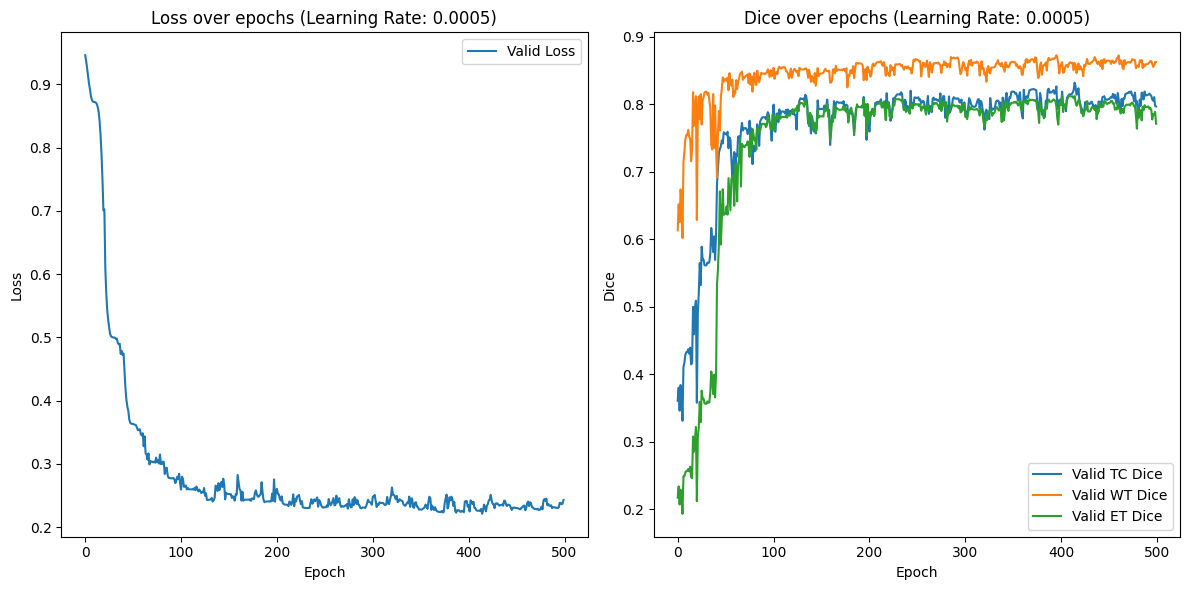

In [77]:
#PLOTTING FOR A LEARNING RATE OF 0.0005
pl_model.plot_metrics()

In [79]:
pl_model.update_csv_files()

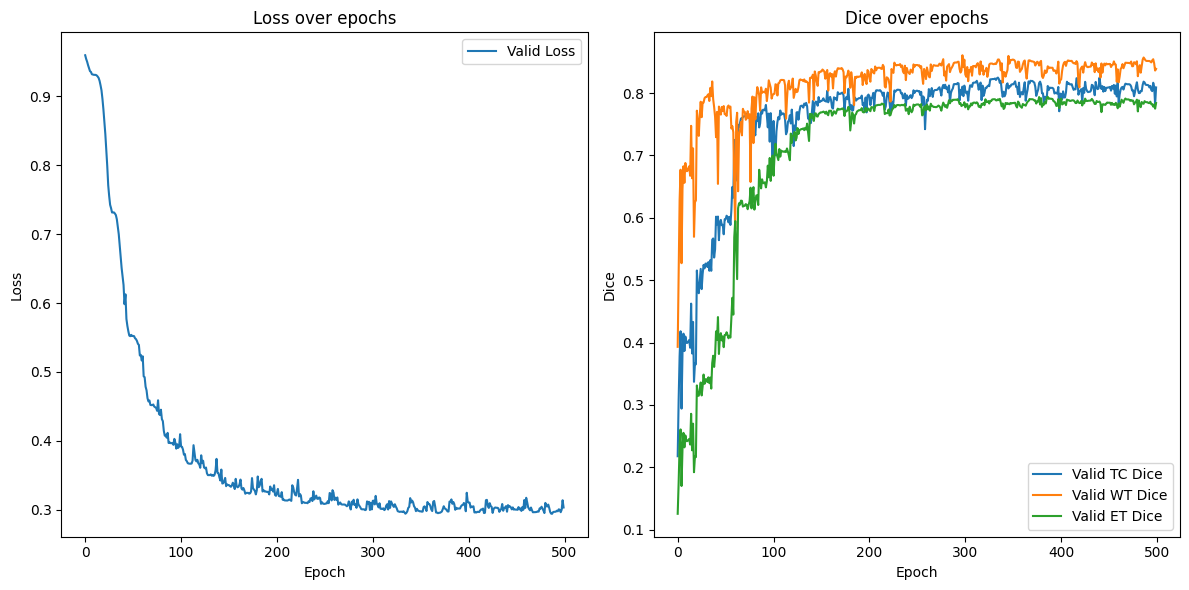

In [59]:
#pl_model.plot_metrics()
#BELOW IS THE PLOT FOR A LEARNING RATE OF 0.0003

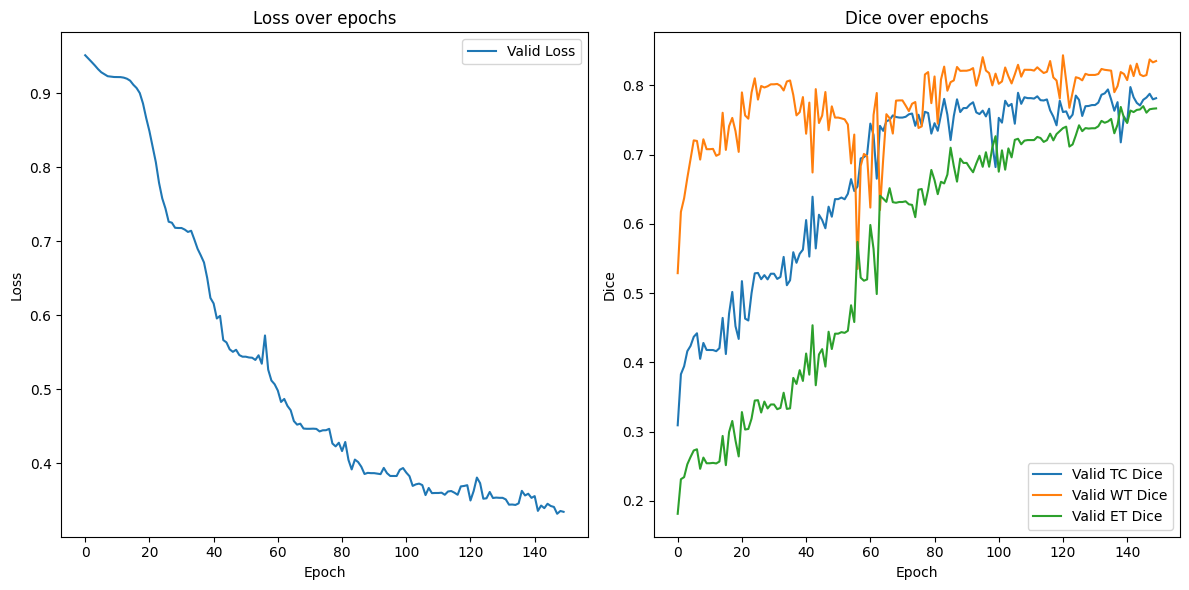

In [87]:
#LOSS AND DICE PLOTS FOR LEARNING RATES OF 0.0003
pl_model.plot_metrics()

In [99]:
#GETTING THE PATHS OF INPUT IMAGES, OUTPUTS AND GROUND TRUTHS 

import matplotlib.pyplot as plt
import os 
import nibabel as nib

outputdirlist = os.listdir('./scratch/Model_Results/Segmentation_Outputs/learning_rate_0.0005')
inputdirlist = os.listdir('./scratch/Model_Results/Corresponding_Inputs/flair/learning_rate_0.0005')
groundtruthlist = os.listdir('./scratch/Model_Results/Ground_Truths/learning_rate_0.0005')

In [100]:
#SORTING THE PATHS IN INCREASING ORDER ACCORDING TO WTDICE, TCDICE AND ETDICE VALUES 

import re

# Function to extract the wtdice value
def get_dice_values(filename):
    wtdice_match = re.search(r'wtdice([0-9]+\.[0-9]+)', filename)
    tcdice_match = re.search(r'tcdice([0-9]+\.[0-9]+)', filename)
    etdice_match = re.search(r'etdice([0-9]+\.[0-9]+)', filename)
    
    wtdice = float(wtdice_match.group(1)) if wtdice_match else 0
    tcdice = float(tcdice_match.group(1)) if tcdice_match else 0
    etdice = float(etdice_match.group(1)) if etdice_match else 0
    
    return wtdice, tcdice, etdice

# Sort filenames based on the wtdice value
sorted_input_dirlist = sorted(inputdirlist, key=get_dice_values)
sorted_outputdirlist = sorted(outputdirlist, key=get_dice_values)
sorted_gtlist = sorted(groundtruthlist, key=get_dice_values)

# Print sorted filenames

print(len(sorted_input_dirlist))

13528


In [101]:
for input_filename in sorted_input_dirlist[:10]:
    print(input_filename)

input_image_wtdice0.8507_tcdice0.8087_etdice0.8448.nii.gz
input_image_wtdice0.8509_tcdice0.9401_etdice0.8875.nii.gz
input_image_wtdice0.8510_tcdice0.8612_etdice0.8762.nii.gz
input_image_wtdice0.8514_tcdice0.9025_etdice0.8870.nii.gz
input_image_wtdice0.8516_tcdice0.9199_etdice0.8075.nii.gz
input_image_wtdice0.8516_tcdice0.9416_etdice0.8760.nii.gz
input_image_wtdice0.8521_tcdice0.8986_etdice0.7513.nii.gz
input_image_wtdice0.8525_tcdice0.9211_etdice0.8755.nii.gz
input_image_wtdice0.8525_tcdice0.9401_etdice0.9221.nii.gz
input_image_wtdice0.8525_tcdice0.9487_etdice0.9321.nii.gz


In [102]:
for input_filename in sorted_outputdirlist[:10]:
    print(input_filename)

segmentation_output_wtdice0.8507_tcdice0.8087_etdice0.8448.nii.gz
segmentation_output_wtdice0.8509_tcdice0.9401_etdice0.8875.nii.gz
segmentation_output_wtdice0.8510_tcdice0.8612_etdice0.8762.nii.gz
segmentation_output_wtdice0.8514_tcdice0.9025_etdice0.8870.nii.gz
segmentation_output_wtdice0.8516_tcdice0.9199_etdice0.8075.nii.gz
segmentation_output_wtdice0.8516_tcdice0.9416_etdice0.8760.nii.gz
segmentation_output_wtdice0.8521_tcdice0.8986_etdice0.7513.nii.gz
segmentation_output_wtdice0.8525_tcdice0.9211_etdice0.8755.nii.gz
segmentation_output_wtdice0.8525_tcdice0.9401_etdice0.9221.nii.gz
segmentation_output_wtdice0.8525_tcdice0.9487_etdice0.9321.nii.gz


In [103]:
for input_filename in sorted_gtlist[:10]:
    print(input_filename)

ground_truth_image_wtdice0.8507_tcdice0.8087_etdice0.8448.nii.gz
ground_truth_image_wtdice0.8509_tcdice0.9401_etdice0.8875.nii.gz
ground_truth_image_wtdice0.8510_tcdice0.8612_etdice0.8762.nii.gz
ground_truth_image_wtdice0.8514_tcdice0.9025_etdice0.8870.nii.gz
ground_truth_image_wtdice0.8516_tcdice0.9199_etdice0.8075.nii.gz
ground_truth_image_wtdice0.8516_tcdice0.9416_etdice0.8760.nii.gz
ground_truth_image_wtdice0.8521_tcdice0.8986_etdice0.7513.nii.gz
ground_truth_image_wtdice0.8525_tcdice0.9211_etdice0.8755.nii.gz
ground_truth_image_wtdice0.8525_tcdice0.9401_etdice0.9221.nii.gz
ground_truth_image_wtdice0.8525_tcdice0.9487_etdice0.9321.nii.gz


In [104]:
import numpy as np 

import matplotlib.pyplot as plt
import os 
import nibabel as nib

outdir = './scratch/Model_Results/Segmentation_Outputs/learning_rate_0.0005'
indir = './scratch/Model_Results/Corresponding_Inputs/flair/learning_rate_0.0005'
gtdir = './scratch/Model_Results/Ground_Truths/learning_rate_0.0005'

for i in range(1000):
    input_path = os.path.join(indir,sorted_input_dirlist[-1000+i])
    output_path = os.path.join(outdir,sorted_outputdirlist[-1000+i])
    gt_path = os.path.join(gtdir,sorted_gtlist[-1000+i])

    x = nib.load(input_path)
    x = x.get_fdata()


    y = nib.load(gt_path)
    y = y.get_fdata()

    y_hat = nib.load(output_path)
    y_hat = y_hat.get_fdata()

    plt.subplot(1, 3, 1)  # (rows, cols, index)
    plt.imshow(x[:,:,75],cmap='gray')
    plt.title('Input')
    plt.axis('off')  # Hide axis

    #Second subplot
    plt.subplot(1, 3, 2)
    img_transposed = np.transpose(y[0,:,:,:,75],(1,2,0))
    plt.imshow(img_transposed)
    plt.title('Ground Truth')
    plt.axis('off')

    #Third subplot
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat[0,0,:,:,75])
    plt.title('Prediction')
    plt.axis('off')

    #Show the plots
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()